# pyPCGA modflow inversion example

## Crosswell tomography

We test:
- true
- no regularization (no_reg)
- gradient smoothing (gs)
- tikonov adaptative (tka)
- gradient smoothing + tikhonov adaptative (gstka)
- tv
- sigmoid
- sigmoid + tv

- Adapted from Application 1 of Lee and Kitanids [WRR 2014] 

(https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014WR015483)

***

> We first generated 870 head observations using crosswell pumping tests (ln 9) from the reference log K field (ln 11) with USGS MODFLOW Flopy python interface.

> In specific, we extracted groundwater at a well and observed 29 stready-state hydraulic heads at the remaining monitoring wells. We repeated these crosswell pumping tests for all 30 well locations (ln 11).  

> Then add the noise (std = 0.5) to observations. Using observations with MODFLOW, can we reconstruct the reference field (ln 11)?

Note the example is not exactly same as Application 1 in Lee and Kitanidis [2014]

Also, the number of MODFLOW simulations is higher than what they reported because we turned on Levenberg-Marquardt and Line Search options in this example. Those additional optimization routines increases the inversion time, but usually results in a very accurate inverse solution even for highly nonlinear problems. 

***

- Parameters

|Description           |                      |   Value |            
|----------------------|:----------------------------------:|:---------------------------:|
|*Geomteric parameters*                          | |       |                                               
| Lx, Ly        | Domain length and width [m]        |        1000, 750|         
| Q             | Pumping rates (m^2/d)              |            25 |           
| Rch           | Recharge rates (m/d)               |           0.001|          
| dx, dy        | Grid size [m]                      |            10|            
|*Geostatistical parameters*     ||                      |                        
| reference mean(logK)    | mean for the reference log K (ln m/d) |            2.5  |          
| reference q(x,x')       | Covariance kernel for the reference log K                  | q(x,x') = 0.002^3 (x-x')^3 |
| q(x,x')            | Covariance kernel used in inversion | q(x,x') = exp(-x/250) |
|*Measurement Error* ||  |
| nobs | Number of measurement | 870 |
| R | Variance of measurement error [m] | 0.5^2 |


In [1]:
import os
import logging
import copy
from pathlib import Path
from typing import Generator, List, Tuple, Iterable, Union, Dict
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.animation import HTMLWriter
from matplotlib.colors import LogNorm, SymLogNorm
from IPython.display import HTML
import nested_grid_plotter as ngp
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
from pyrtid.utils import (
    indices_to_node_number,
    node_number_to_indices,
    GaussianFilter,
    extract_hess_inv_diag,
)
from pyrtid.inverse.params import (
    get_gridded_archived_gradients,
)
from pyrtid.inverse.regularization import (
    GeostatisticalRegularizator,
    FFTCovarianceMatrix,
    DenseCovarianceMatrix,
    eigen_factorize_cov_mat,
    MeanPriorTerm,
)
import numpy as np
from pyrtid.utils.types import NDArrayFloat
import scipy as sp
from scipy.sparse import csc_array
import gstlearn as gl
from sksparse.cholmod import cholesky
from pyrtid.utils import spde

- Set-up logging level

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")
print("This is a print test")

INFO:root:this is a logging test


This is a print test


- Check package/software versions

In [3]:
pyrtid.utils.show_versions()

INFO:root:Current version = 0.1.2

INFO:root:Used packages version:

INFO:root:iterative_ensemble_smoother = 0.1.1
INFO:root:gstools                     = 1.5.1
INFO:root:matplotlib                  = 3.8.3
INFO:root:nested_grid_plotter         = 1.1.1
INFO:root:numdiftools                 = 0.9.41
INFO:root:numpy                       = 1.25.2
INFO:root:pyesmda                     = 0.4.3
INFO:root:pypcga                      = 0.1.0
INFO:root:scipy                       = 1.10.1
INFO:root:sksparse                    = 0.4.12
INFO:root:stochopy                    = 2.3.0


- Create a directory to store the exported figures

In [4]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [5]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    # "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

## Forward problem

- Grid definition

In [6]:
nx = 100
ny = 75
nz = 1
dx = 10  # m
dy = 10  # m
dz = 1

- Location of pumping wells (obs_locmat)

In [7]:
obs_locmat = np.zeros((nz, ny, nx), dtype=bool)
obs_locs: List[Tuple[int, int]] = []
for i in range(5, 71, 16):  # y
    for j in range(9, 96, 16):  # x
        obs_locmat[0, i, j] = 1
        obs_locs.append((j, i))

Q_locs_idx = np.where(obs_locmat == True)
Q_locs = []
for Q_loc in zip(Q_locs_idx[0], Q_locs_idx[1], Q_locs_idx[2]):
    Q_locs.append(Q_loc)

- x,y coordinates for plotting

In [8]:
x = np.linspace(0.0 + dx / 2.0, nx * dx - dx / 2.0, nx)
y = np.linspace(0.0 + dy / 2.0, ny * dy - dy / 2.0, ny)
XX, YY = np.meshgrid(x, y)
pts = np.hstack((XX.ravel()[:, np.newaxis], YY.ravel()[:, np.newaxis]))

- Pumping/monitoring well locations

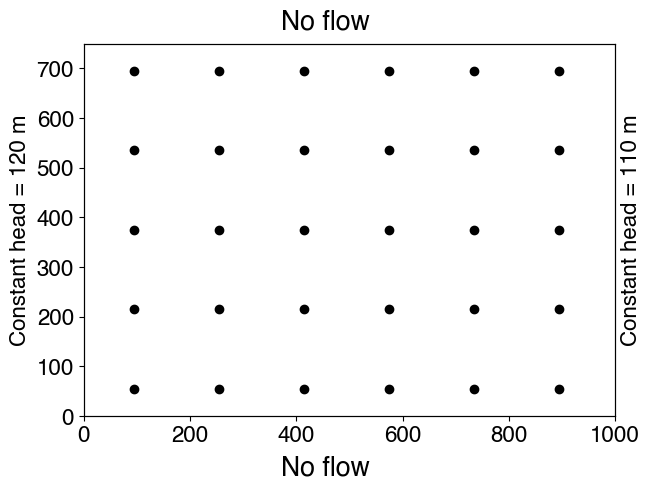

In [9]:
plotter = ngp.NestedGridPlotter()
ax = plotter.axes[0]
idx = np.where(obs_locmat == 1)
for i, j in zip(idx[1], idx[2]):
    ax.plot(x[j], y[i], "ko")
ax.set_xlim(0, nx * dx)
ax.set_ylim(0, ny * dy)
ax.set_ylabel("Constant head = 120 m")
ax2 = ax.twinx()
ax2.set_ylabel("Constant head = 110 m")
# ax.set_ylabel("Y [m]", fontweight="bold")
ngp.hide_axis_ticklabels(ax2)
plotter.fig.supxlabel("No flow")
plotter.fig.suptitle("No flow")

fname = "well_locations"
for format in ["png", "pdf"]:
    plt.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- This example is Hydraulic tomography - crosswell pumping test setting
- Load reference value for comparison purpose with its plot

Note: in the demonstrator, we can adjust the permeability (m/s), so we need to convert these values to permeability ones



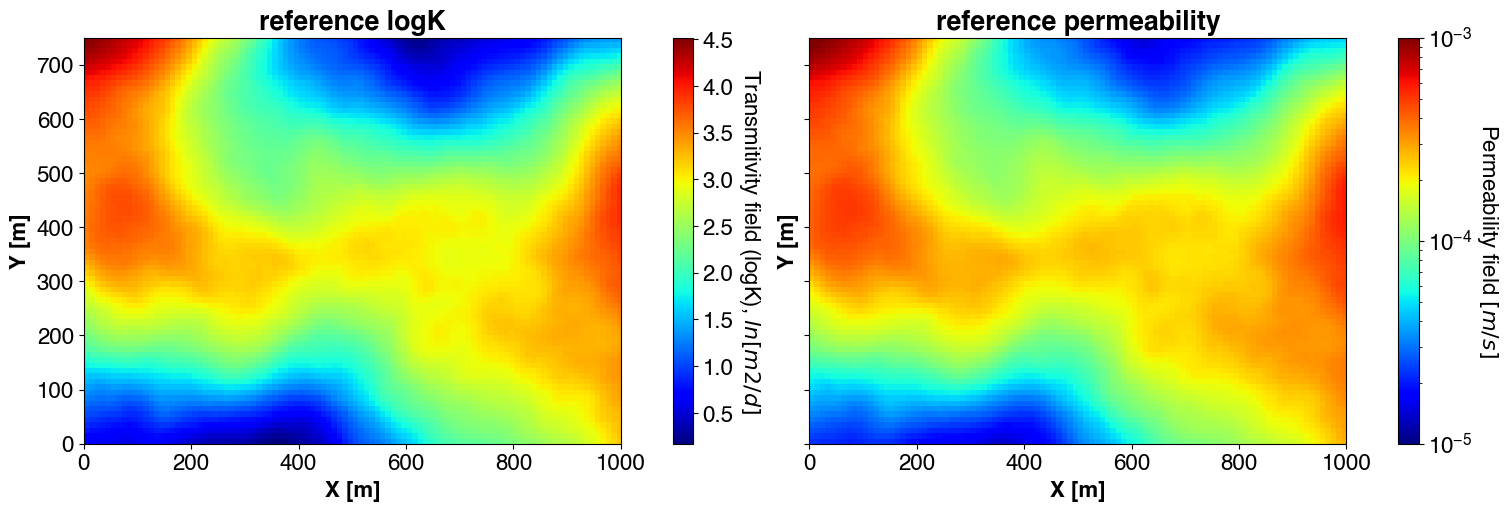

In [10]:
def log_transmitivity_to_permeability(x: NDArrayFloat) -> NDArrayFloat:
    """Convert a transmitivity in ln[m2/d] to a permeability in [m/s]."""
    return np.exp(x) / 3600 / 24


def permeability_to_log_transmitivity(x: NDArrayFloat) -> NDArrayFloat:
    """Convert a permeability in [m/s] to a transmitivity in ln[m2/d]."""
    return np.log(x * 3600 * 24)


logT_reference: NDArrayFloat = np.loadtxt("../../data/reference_logK.txt")
perm_reference = log_transmitivity_to_permeability(logT_reference)
perm_reference_2d = perm_reference.reshape(ny, nx).T
logT_reference_3d = logT_reference.reshape(nz, ny, nx)
logT_reference_2d = logT_reference_3d[0, :, :].T

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (15, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

# Plot the permeability
ngp.multi_imshow(
    axes=[plotter.get_axis("ax1-1")],
    fig=plotter.fig,
    data={"reference logK": logT_reference_2d},
    cbar_title="Transmitivity field (logK), $ln[m2/d]$",
    imshow_kwargs={"cmap": plt.get_cmap("jet"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Y [m]",
)

ngp.multi_imshow(
    axes=[plotter.get_axis("ax1-2")],
    fig=plotter.fig,
    data={"reference permeability": perm_reference_2d},
    cbar_title="Permeability field $[m/s]$",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "norm": LogNorm(vmin=1e-5, vmax=1e-3),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
    },
    xlabel="X [m]",
    ylabel="Y [m]",
)

- Load observations (head) -> 30 wells = 30 pumping tests with 29 observations because we do no measure at the pumping well

In [11]:
obs_data: NDArrayFloat = np.loadtxt("../../data/obs.txt").reshape(30, -1)
obs_data.shape

(30, 29)

In [12]:
grid_obs = np.full((len(obs_locs), nx, ny), fill_value=np.nan, dtype=float)
for i, obs_loc in enumerate(obs_locs):
    j = 0
    for obs_loc2 in obs_locs:
        if obs_loc2 != obs_loc:
            grid_obs[i][obs_loc2] = obs_data[i][j]
            j += 1

# Forward Model with PyRTID

- Creation of a base model

In [13]:
duration_in_days = 31
duration_in_s = duration_in_days * 3600 * 24
dt_init = 3600 * 12  # timestep in seconds
dt_min = dt_init
dt_max = dt_init

# Simulation on 31 days. We use a 4h timestep.
time_params = dmfwd.TimeParameters(
    duration=duration_in_s, dt_init=dt_init, dt_max=dt_max, dt_min=dt_min
)

geometry = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dy)
fl_params = dmfwd.FlowParameters(
    permeability=8.0e-5,
    storage_coefficient=1e-6,
    regime=dmfwd.FlowRegime.STATIONARY,
    crank_nicolson=1.0,
)
tr_params = dmfwd.TransportParameters(is_numerical_acceleration=True, is_skip_rt=True)

base_model = dmfwd.ForwardModel(geometry, time_params, fl_params, tr_params)

- Add boundary conditions and regional recharge

In [14]:
# Add a regional recharge -> 1000 m3/d = 1000 / 3600 / 24 m3/s
flw_reg = 1000.0 / 3600 / 24
recharge_source = dmfwd.SourceTerm(
    "aquifer_recharge",
    node_ids=np.arange(nx * ny),  # -> on the full domain
    times=np.arange(time_params.nt) * time_params.dt,
    flowrates=np.repeat(flw_reg, time_params.nt),
    concentrations=np.repeat(0.0, time_params.nt),
)
base_model.add_src_term(recharge_source)

# Boundary conditions
# Left border (x = 0) at 120 m
base_model.add_boundary_conditions(dmfwd.ConstantHead(span=(slice(0, 1), slice(None))))
base_model.fl_model.set_initial_head(120.0, span=(slice(0, 1), slice(None)))
# Right border (x = xmax) at 110 m
base_model.add_boundary_conditions(
    dmfwd.ConstantHead(span=(slice(nx - 1, nx), slice(None)))
)
base_model.fl_model.set_initial_head(110.0, span=(slice(nx - 1, nx), slice(None)))

- Create the source terms for the pumping: one pumping test per day at -25 m3/h

In [15]:
flowrates = np.array([-25.0 / 3600, 0.0])
for day in range(1, int(duration_in_days)):
    ix, iy = obs_locs[day - 1]
    source_term = dmfwd.SourceTerm(
        "well pumping test # {day}",
        node_ids=np.array(
            indices_to_node_number(ix=ix, nx=nx, iy=iy, ny=ny)
        ),  # -> on the full domain
        times=np.array([day * 3600 * 24, (day + 0.5) * 3600 * 24]),
        flowrates=flowrates,
        concentrations=np.zeros((2,)),
    )
    base_model.add_src_term(source_term)

- Create two models with different permeabilities

In [16]:
# copy the base model
model_reference = copy.deepcopy(base_model)
# update permeability
model_reference.fl_model.permeability = perm_reference_2d
# solve the flow problem
dmfwd.ForwardSolver(model_reference).solve(is_verbose=True)

In [17]:
# copy the base model
model_estimate = copy.deepcopy(base_model)
# update permeability
model_estimate.fl_model.permeability[:, :] = log_transmitivity_to_permeability(1.0)
# solve the flow problem
dmfwd.ForwardSolver(model_estimate).solve()

- Check pumping

In [18]:
model_estimate.time_params.times

array([      0,   43200,   86400,  129600,  172800,  216000,  259200,
        302400,  345600,  388800,  432000,  475200,  518400,  561600,
        604800,  648000,  691200,  734400,  777600,  820800,  864000,
        907200,  950400,  993600, 1036800, 1080000, 1123200, 1166400,
       1209600, 1252800, 1296000, 1339200, 1382400, 1425600, 1468800,
       1512000, 1555200, 1598400, 1641600, 1684800, 1728000, 1771200,
       1814400, 1857600, 1900800, 1944000, 1987200, 2030400, 2073600,
       2116800, 2160000, 2203200, 2246400, 2289600, 2332800, 2376000,
       2419200, 2462400, 2505600, 2548800, 2592000, 2635200, 2678400])

Text(0, 0.5, 'flowrates [m3/s]')

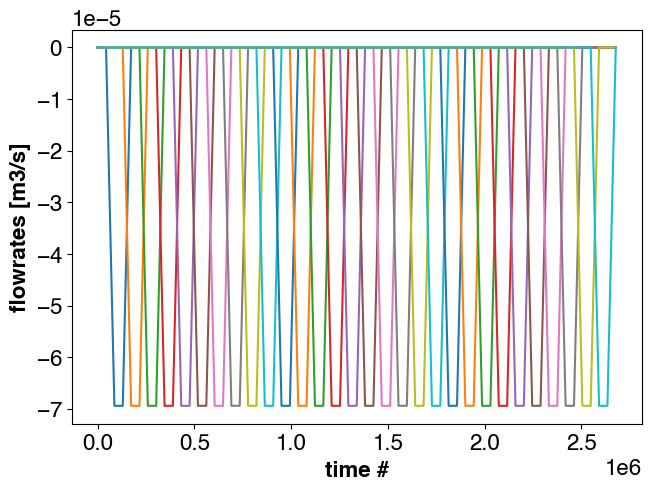

In [19]:
fl_sources = model_estimate.fl_model.unitflow

fig, ax = plt.subplots()
for i in range(len(obs_locs)):
    ix, iy = obs_locs[i]
    ax.plot(model_estimate.time_params.times, fl_sources[ix, iy, :])
ax.set_xlabel("time #", fontweight="bold")
ax.set_ylabel("flowrates [m3/s]", fontweight="bold")

- Plot one time step

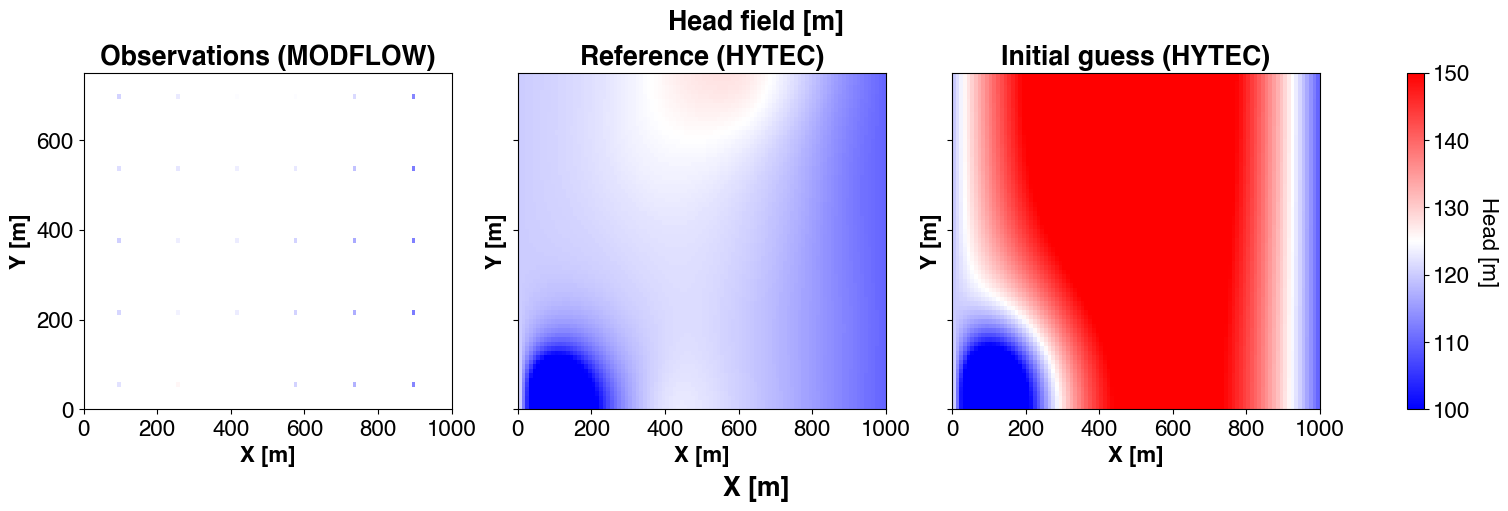

In [20]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (15, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

well_id = 2
ngp.multi_imshow(
    axes=[plotter.get_axis(ax_name) for ax_name in ["ax1-1", "ax1-2", "ax1-3"]],
    data={
        # Warning: observation 0 matches sample 1
        "Observations (MODFLOW)": grid_obs[well_id],
        "Reference (HYTEC)": model_reference.fl_model.head[:, :, well_id + 1],
        "Initial guess (HYTEC)": model_estimate.fl_model.head[:, :, well_id + 1],
    },
    fig=plotter.fig,
    cbar_title="Head [m]",
    imshow_kwargs={"vmin": 100, "vmax": 150, "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Y [m]",
)

plotter.subfigs["fig0"].suptitle("Head field [m]", fontweight="bold")
plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")

fname = "head_field_reference_vs_initial_guess"
for format in ["png", "pdf"]:
    plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Make an animated version

In [21]:
# plotter = ngp.AnimatedPlotter(
#     fig_params={"constrained_layout": True, "figsize": (15, 5)},
#     subplots_mosaic_params={
#         "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
#     },
# )

# nb_frames = grid_obs.shape[0]
# plotter.animated_multi_imshow(
#     ax_names=["ax1-1", "ax1-2", "ax1-3"],
#     data={
#         # Warning: observation 0 matches sample 1
#         "Observations (MODFLOW)": np.transpose(grid_obs, axes=(1, 2, 0)),
#         "Reference (HYTEC)": model_reference.fl_model.head[:, :, 3::2],
#         "Initial guess (HYTEC)": model_estimate.fl_model.head[:, :, 3::2],
#     },
#     cbar_title="Head [m]",
#     nb_frames=nb_frames,
#     imshow_kwargs={"vmin": 100, "vmax": 150, "extent": [0.0, nx * dx, 0.0, ny * dy]},
#     xlabel="X [m]",
#     ylabel="Y [m]",
# )

# plotter.subfigs["fig0"].suptitle("Head field [m]", fontweight="bold")

# plotter.close()
# plotter.animate(nb_frames=nb_frames)

# # Save the animation locally on the computer
# fname_html = fig_save_path.joinpath(
#     "head_field_reference_vs_initial_guess_animated.html"
# )
# writer = HTMLWriter(fps=5, embed_frames=True)
# writer.frame_format = "svg"  # Ensure svg format
# plotter.animation.save(str(fname_html), writer=writer)

# # Display the animation
# HTML(fname_html.read_text())

In [22]:
# def get_frame_time_label(
#     nb_frames: int, ltimes: Union[List[float], NDArrayFloat]
# ) -> Generator[str, None, None]:
#     """
#     Generator of time labels (in d).

#     Parameters
#     ----------
#     nb_frames : int
#         Number of frames in the animation.
#     ltimes : List[float]
#         List of times. The length of the list must be equal or greater than `nb_frames`.
#         Times are expected in seconds.

#     Yields
#     ------
#     Generator[str, None, None]
#     """
#     # subtract -1 to nb_steps and _nb_frames so that when
#     # frame_index = 0, we get the first element of ltimes, and when
#     # frame_index = _nb_frames - 1, we get the last element of ltimes.
#     ts_btw_frames = (len(ltimes) - 1) / (nb_frames - 1)
#     for frame in range(nb_frames):
#         yield f"time = {ltimes[int(ts_btw_frames * frame)] / 3600 / 24:.1f} d"


# plotter = ngp.AnimatedPlotter(
#     fig_params={"constrained_layout": True, "figsize": (7, 12)},
#     subplots_mosaic_params={
#         "fig0": dict(
#             mosaic=[[f"ax{i+1}-{j+1}" for j in range(2)] for i in range(5)],
#             sharey=True,
#             sharex=True,
#         )
#     },
# )

# nb_frames = min(model_estimate.time_params.nt, 5)
# _times = list(get_frame_time_label(nb_frames, model_reference.time_params.times))


# def get_frame_id(frame_index: int):
#     return int((model_estimate.time_params.nt - 1) / (nb_frames - 1) * frame_index)


# cbar = ngp.multi_imshow(
#     axes=plotter.axes[::2],
#     fig=plotter.fig,
#     data={
#         f"{_times[index]}": model_reference.fl_model.head[:, :, get_frame_id(index)]
#         for index in range(nb_frames)
#     },
#     imshow_kwargs={
#         "extent": [0.0, nx * dx, 0.0, ny * dy],
#         "vmin": 100.0,
#         "vmax": 150.0,
#         "aspect": "equal",
#         # "cmap": plt.get_cmap("jet"),
#     },
#     # cbar_kwargs={"orientation":None, "location":"bottom", "shrink": 0.5, "pad":0.0},
#     cbar_kwargs={"shrink": 0.4},
#     cbar_title="Uranium",
# )
# # no need to duplicate cbars
# cbar.remove()

# cbar = ngp.multi_imshow(
#     axes=plotter.axes[1::2],
#     fig=plotter.fig,
#     data={
#         f"{_times[index]}": model_estimate.fl_model.head[:, :, get_frame_id(index)]
#         for index in range(nb_frames)
#     },
#     imshow_kwargs={
#         "extent": [0.0, nx * dx, 0.0, ny * dy],
#         "vmin": 100.0,
#         "vmax": 150.0,
#         "aspect": "equal",
#         # "cmap": plt.get_cmap("jet"),
#     },
#     # cbar_kwargs={"orientation":None, "location":"bottom", "shrink": 0.5, "pad":0.0},
#     cbar_kwargs={"shrink": 0.4},
#     cbar_title="Head [m]",
# )
# # cbar.ax.get_xaxis().labelpad = 00
# # cbar.ax.set_xlabel("H2SO4 [g/l]", rotation=0)

# plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")
# plotter.subfigs["fig0"].supylabel("Y [m]", fontweight="bold")
# # plotter.subfigs["fig0"].suptitle("Uranium: Reference (left) vs. Initial Guess (right)", fontweight="bold")

# # Save the animation locally on the computer
# fname = fig_save_path.joinpath("head_reference_vs_ig_map")
# for format in ["png", "pdf"]:
#     plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Compare the data from HYTEC with the one from MODFLOW for the "reference" model

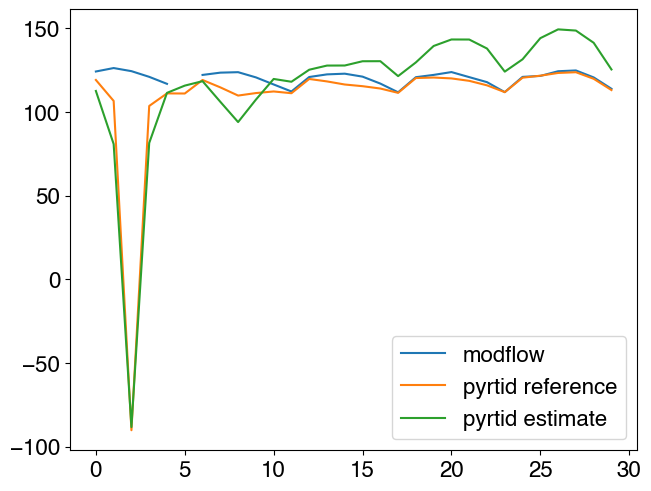

In [23]:
pumping_test_id = 5  # index of the well pumping test

dat_modflow: NDArrayFloat = np.zeros(len(obs_locs))
dat_pyrtid_reference: NDArrayFloat = np.zeros(len(obs_locs))
dat_pyrtid_estimate: NDArrayFloat = np.zeros(len(obs_locs))

for i, obs_loc in enumerate(obs_locs):
    dat_modflow[i] = grid_obs[pumping_test_id][obs_loc[0], obs_loc[1]]
    dat_pyrtid_reference[i] = model_reference.fl_model.head[
        :, :, (pumping_test_id + 1)
    ][obs_loc[0], obs_loc[1]]
    dat_pyrtid_estimate[i] = model_estimate.fl_model.head[:, :, (pumping_test_id + 1)][
        obs_loc[0], obs_loc[1]
    ]

plt.plot(dat_modflow, label="modflow")
plt.plot(dat_pyrtid_reference, label="pyrtid reference")
plt.plot(dat_pyrtid_estimate, label="pyrtid estimate")
plt.legend()

fname = f"heads_modflow_vs_hytec_for_pumping_test_{pumping_test_id}"
for format in ["png", "pdf"]:
    plt.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Compare the same data but looked at a specific well location

In [24]:
np.transpose(grid_obs, axes=(1, 2, 0)).shape

(100, 75, 30)

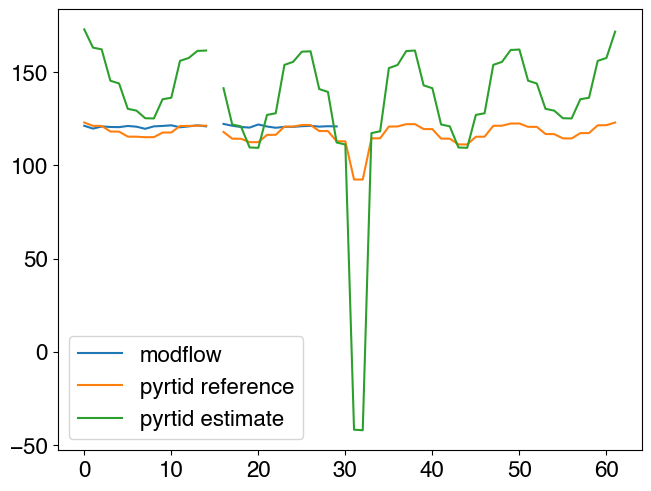

In [25]:
well_id = 15  # index of the well pumping test
obs_loc = obs_locs[well_id]
ix, iy = obs_loc

dat_modflow = np.transpose(grid_obs, axes=(1, 2, 0))[ix, iy, :]
dat_pyrtid_reference = model_reference.fl_model.head[
    ix, iy, 1:
].copy()  # We do not count time 0
dat_pyrtid_reference[well_id] = np.nan  # Exclude the day of pumping
dat_pyrtid_estimate = model_estimate.fl_model.head[
    ix, iy, 1:
].copy()  # We do not count time 0
dat_pyrtid_estimate[well_id] = np.nan  # Exclude the day of pumping

plt.plot(dat_modflow, label="modflow")
plt.plot(dat_pyrtid_reference, label="pyrtid reference")
plt.plot(dat_pyrtid_estimate, label="pyrtid estimate")
plt.legend()

In [26]:
noise_std = 0.5  # This is an absolute value


def get_white_noise(shape: Iterable[int]) -> NDArrayFloat:
    """
    Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return np.random.default_rng(2021).normal(
        mean_noise, noise_std, size=np.array(shape)
    )


obs_noise: NDArrayFloat = get_white_noise((len(obs_locs), 29))

# Inversion

- Define observables

In [27]:
observables: List[dminv.Observable] = []
for count, (ix, iy) in enumerate(obs_locs):
    vals = model_reference.fl_model.head[ix, iy, 3::2]  # 30 measures from day 1 to 30
    times = model_reference.time_params.times[3::2]
    # Remove the pumping day
    vals = np.delete(vals, count)
    times = np.delete(times, count)

    observables.append(
        dminv.Observable(
            state_variable=dminv.StateVariable.HEAD,
            node_indices=np.array(indices_to_node_number(ix=ix, nx=nx, iy=iy, ny=ny)),
            times=times,
            values=vals + obs_noise[count],
            uncertainties=noise_std,
        )
    )

- Create a simulation for inversion based

- true
- no regularization (no_reg)
- gradient smoothing (gs)
- tikonov adaptative (tka)
- gradient smoothing + tikhonov adaptative (gstka)
- tv (tva)
- sigmoid (sg)
- sigmoid + tv (gstv)

In [28]:
solver_config = dminv.LBFGSBSolverConfig(
    maxfun=30,
    maxiter=30,
    ftol=1e-7,
    gtol=1e-7,
    is_check_gradient=False,
    is_adj_numerical_acceleration=True,
    afpi_eps=1e-10,
)

In [29]:
# dict to store results
params: Dict[str, dminv.AdjustableParameter] = {}
adjusted_models: Dict[str, dmfwd.ForwardModel] = {}
inverse_models: Dict[str, dminv.InverseModel] = {}
executors: Dict[str, dminv.LBFGSBInversionExecutor] = {}

In [30]:
case = "no_reg"
params[case] = dminv.AdjustableParameter(
    name=dminv.ParameterName.PERMEABILITY,
    lbounds=1e-6,
    ubounds=0.1,
    preconditioner=dminv.LogTransform(),
)

case = "gs"
params[case] = dminv.AdjustableParameter(
    name=dminv.ParameterName.PERMEABILITY,
    lbounds=1e-6,
    ubounds=0.1,
    preconditioner=dminv.LogTransform(),
    filters=[GaussianFilter(sigmas=2.5)],
)

case = "tka"
params[case] = dminv.AdjustableParameter(
    name=dminv.ParameterName.PERMEABILITY,
    lbounds=1e-6,
    ubounds=0.1,
    preconditioner=dminv.LogTransform(),
    regularizators=dminv.regularization.TikhonovRegularizator(
        dx, dy, preconditioner=dminv.LogTransform()
    ),
    reg_weight_update_strategy=dminv.regularization.AdaptiveUCRegweight(1.0),
)

case = "gstka"
params[case] = dminv.AdjustableParameter(
    name=dminv.ParameterName.PERMEABILITY,
    lbounds=1e-6,
    ubounds=0.1,
    preconditioner=dminv.LogTransform(),
    filters=[GaussianFilter(sigmas=2.5)],
    regularizators=dminv.regularization.TikhonovRegularizator(
        dx, dy, preconditioner=dminv.LogTransform()
    ),
    reg_weight_update_strategy=dminv.regularization.AdaptiveUCRegweight(1.0),
)

case = "tva"
params[case] = dminv.AdjustableParameter(
    name=dminv.ParameterName.PERMEABILITY,
    lbounds=1e-6,
    ubounds=0.1,
    preconditioner=dminv.LogTransform(),
    regularizators=dminv.regularization.TVRegularizator(
        dx, dy, preconditioner=dminv.LogTransform()
    ),
    reg_weight_update_strategy=dminv.regularization.AdaptiveUCRegweight(1.0),
)

# case = "sg"
# params[case] = dminv.AdjustableParameter(
#     name=dminv.ParameterName.PERMEABILITY,
#     lbounds=1e-6,
#     ubounds=0.1,
#     preconditioner=dminv.SigmoidRescalerBounded(
#         old_lbound=1e-6, old_ubound=1e-2, rate=2.0, is_log10=True
#     ),
# )

# case = "sgtva"
# params[case] = dminv.AdjustableParameter(
#     name=dminv.ParameterName.PERMEABILITY,
#     lbounds=1e-6,
#     ubounds=0.1,
#     preconditioner=dminv.SigmoidRescalerBounded(
#         old_lbound=1e-6, old_ubound=1e-2, rate=2.0, is_log10=True
#     ),
#     regularizators=dminv.regularization.TVRegularizator(
#         dx, dy, preconditioner=dminv.LogTransform()
#     ),
#     reg_weight_update_strategy=dminv.regularization.RegWeightUpdateStrategy.ADAPTIVE_UC,
# )

- Add one case with SPDE

In [31]:
def get_exp_kernel_precision_matrix() -> csc_array:
    param = 0.5  # alpha for exponential kernel
    sill = (
        1.0
    ) ** 2  # variance corrected (ask nicolas why the variance is not correct)
    nugget = 0.0  # no nugget effect

    # We use gstlearn
    model_spde = gl.Model.createFromParam(
        gl.ECov.BESSEL_K, param=param, ranges=[250.0, 250.0], sill=sill
    )
    model_spde.addCovFromParam(gl.ECov.NUGGET, sill=nugget)
    grid_spde = gl.DbGrid.create([nx, ny], [dx, dy])
    mesh_spde = gl.MeshETurbo(grid_spde)
    exp_spde = gl.SPDE(
        model=model_spde,
        domain=grid_spde,
        data=None,
        calcul=gl.ESPDECalcMode.SIMUNONCOND,
        mesh=mesh_spde,
    )
    return exp_spde.getPrecisionOpCs().getQToTriplet().toTL()


# Buidl the precision matrix
Q = get_exp_kernel_precision_matrix()

# Decompose with cholesky
cholQ = cholesky(Q)


# Create a preconditioner with the gradual deformation method couple with
# Non-conditional SPDE simulations
ne = 100
gdpncs = dminv.GDPNCS(
    ne,
    Q_nc=Q,
    estimated_mean=float(0.0),
    cholQ_nc=cholQ,
    random_state=2024,
    is_update_mean=True,  # update the mean as well
)

# We apply three successive preconditionning:
# 1) A first one to convert m/s to m/d
# 2) A second one to log
# 3) A third one to convert ppm to white noise linear combinaison weights through the
# gradual deformation + SPDE approach
pcd = dminv.ChainedTransforms(
    [
        dminv.LinearTransform(slope=1.0 * 3600.0 * 24.0, y_intercept=0.0),
        dminv.LogTransform(),
        gdpncs,
    ]
)

# Generate an initial permeability field
estimate_perm = pcd.backtransform(
    np.hstack((gdpncs.theta, gdpncs.estimated_mean))
).reshape(nx, ny, order="F")

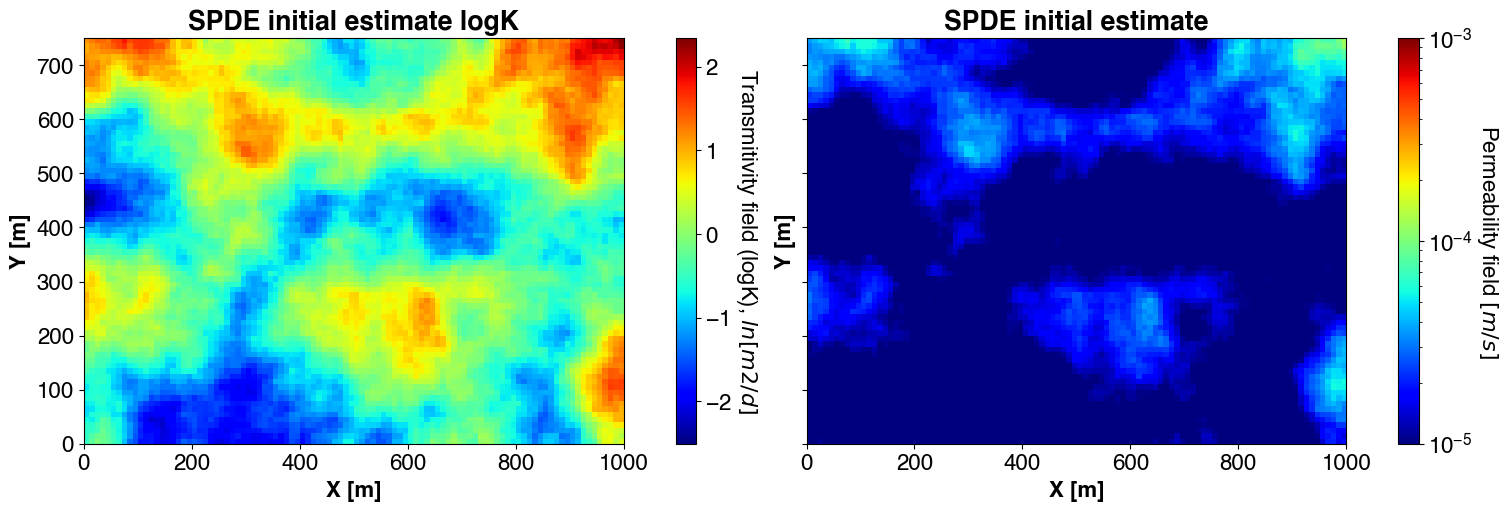

In [32]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (15, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

# Plot the permeability
ngp.multi_imshow(
    axes=[plotter.get_axis("ax1-1")],
    fig=plotter.fig,
    data={
        "SPDE initial estimate logK": permeability_to_log_transmitivity(estimate_perm)
    },
    cbar_title="Transmitivity field (logK), $ln[m2/d]$",
    imshow_kwargs={"cmap": plt.get_cmap("jet"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Y [m]",
)

ngp.multi_imshow(
    axes=[plotter.get_axis("ax1-2")],
    fig=plotter.fig,
    data={"SPDE initial estimate": estimate_perm},
    cbar_title="Permeability field $[m/s]$",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "norm": LogNorm(vmin=1e-5, vmax=1e-3),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
    },
    xlabel="X [m]",
    ylabel="Y [m]",
)

fname = fig_save_path.joinpath("GDPNCS_initial_perm")
for format in ["png", "pdf"]:
    plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [33]:
case = "gdncs"
params[case] = dminv.AdjustableParameter(
    name=dminv.ParameterName.PERMEABILITY,
    lbounds=1e-6,
    ubounds=0.1,
    preconditioner=pcd,
)

In [34]:
case = "spde_prior"
pcd = dminv.ChainedTransforms(
    [
        dminv.LinearTransform(slope=1.0 * 3600.0 * 24.0, y_intercept=0.0),
        dminv.LogTransform(),
    ]
)
params[case] = dminv.AdjustableParameter(
    name=dminv.ParameterName.PERMEABILITY,
    lbounds=1e-6,
    ubounds=0.1,
    preconditioner=pcd,
    regularizators=dminv.regularization.GeostatisticalRegularizator(
        cov_m=dminv.regularization.SparseInvCovarianceMatrix(Q),
        prior=dminv.regularization.MeanPriorTerm(),
        preconditioner=pcd,
    ),
    reg_weight_update_strategy=dminv.regularization.ConstantRegWeight(1.0),
)

case = "spde_prior_adaptive"
params[case] = copy.deepcopy(params["spde_prior"])
params[case].reg_weight_update_strategy = dminv.regularization.AdaptiveUCRegweight(1.0)

In [35]:
np.mean(estimate_perm)

1.305137392834844e-05

## Run inversions

- Function to create the inversion executor for a given case

In [36]:
def create_executor(_case: str) -> None:
    adjusted_models[_case] = copy.deepcopy(model_estimate)
    inverse_models[_case] = dminv.InverseModel(params[_case], observables)
    executors[_case] = dminv.LBFGSBInversionExecutor(
        adjusted_models[_case], inverse_models[_case], solver_config
    )


for case in params.keys():
    create_executor(case)

- Function to compute the observations LS loss function and regularization term (should be zero)

In [37]:
def get_loss_ls(_case) -> float:
    return executors[case].eval_scaled_loss(
        params[case].preconditioner(params[case].values), is_save_state=False
    )


# Test with the first case
first_case = list(params.keys())[0]
# first_case = "spde_prior_adaptive"
# first_case = "gdncs"
loss_ls = get_loss_ls(first_case)
assert loss_ls == 1.0  # should be one because of the scaling

INFO:root:- Running forward model # 1
INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 723563.8257788877
INFO:root:Loss (obs fit) / Nobs = 831.6825583665376
INFO:root:Loss (regularization) = 0.0
INFO:root:Scaling factor        = 1.3820480852861041e-06
INFO:root:Loss (scaled)         = 1.0



- Compute the LS loss gradient with respect to the parameters

In [38]:
# Test with the first case as well
grad_ls = executors[case].eval_scaled_loss_gradient(
    params[first_case].preconditioner(params[first_case].values),
    is_verbose=True,
    is_save_state=False,
)

INFO:root:- Running gradient # 1
INFO:root:- Gradient eval # 1 over



- Plot the adjoint sources and head

In [39]:
# plotter = ngp.AnimatedPlotter(
#     fig_params={"constrained_layout": True, "figsize": (15, 5)},
#     subplots_mosaic_params={
#         "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
#     },
# )

# nb_frames = grid_obs.shape[0]
# plotter.animated_multi_imshow(
#     ax_names=["ax1-1"],
#     data={
#         "Adjoint sources": executor.adj_model.a_fl_model.a_head_sources.toarray().reshape(
#             (nx, ny, -1), order="F"
#         ),
#     },
#     cbar_title="Head error [m]",
#     nb_frames=nb_frames + 1,
#     imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
#     xlabel="X [m]",
#     ylabel="Y [m]",
# )

# plotter.animated_multi_imshow(
#     ax_names=["ax1-2"],
#     data={
#         "Adjoint head": executor.adj_model.a_fl_model.a_head,
#     },
#     cbar_title="Adjoit head",
#     nb_frames=nb_frames,
#     imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
#     xlabel="X [m]",
#     ylabel="Y [m]",
# )

# plotter.subfigs["fig0"].suptitle("Adjoint sources and head", fontweight="bold")

# plotter.close()
# plotter.animate(nb_frames=nb_frames)

# # Save the animation locally on the computer
# fname_html = fig_save_path.joinpath(
#     "head_field_reference_vs_initial_guess_animated.html"
# )
# writer = HTMLWriter(fps=5, embed_frames=True)
# writer.frame_format = "svg"  # Ensure svg format
# plotter.animation.save(str(fname_html), writer=writer)

# # Display the animation
# HTML(fname_html.read_text())

In [40]:
# plt.imshow(
#     grad_ls.reshape(nx, ny, order="F").T, origin="lower", cmap="bwr", aspect="equal"
# )
# plt.colorbar()

In [41]:
res = executors[first_case].run()
logging.info(res)

INFO:root:============================= Inversion Parameters =============================
INFO:root:Method                                            : L-BFGS-B (PyRTID)
INFO:root:
INFO:root:Number of adjusted parameters                     : 1
INFO:root:Number of unknowns (adjusted values)              : 7500
INFO:root:Number of observables                             : 30
INFO:root:Number of observation data points (values)        : 870
INFO:root:================================================================================
INFO:root:- Running forward model # 1
INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 723563.8257920693
INFO:root:Loss (obs fit) / Nobs = 831.6825583816889
INFO:root:Loss (regularization) = 0.0
INFO:root:Scaling factor        = 1.3820480852609265e-06
INFO:root:Loss (scaled)         = 1.0

INFO:root:- Running gradient # 1
INFO:root:- Gradient eval # 1 over

INFO:root:- Running forward model # 2
INFO:root:- Run # 2 over
INFO:root:Loss (obs fit)        

In [42]:
def plot_inv_animation_case(_case: str) -> HTML:
    plotter = ngp.AnimatedPlotter(
        fig_params={"figsize": (12.5, 8.0)}, subfigs_params={"nrows": 2, "ncols": 2}
    )

    # 1 frame per solver iteration
    nb_frames: int = inverse_models[_case].nb_f_calls

    aligned_adjoint_gradients = get_gridded_archived_gradients(
        params[_case], is_adjoint=True
    )

    # 1) Gradient evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-1"],
        data={
            "Gradient": aligned_adjoint_gradients,
        },
        # cbar_title="Adjoit head",
        nb_frames=nb_frames,
        imshow_kwargs={
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "aspect": "equal",
            "norm": SymLogNorm(linthresh=0.5),
        },
        xlabel="X [m]",
        ylabel="Y [m]",
        is_symmetric_cbar=True,
    )
    plotter.get_axis("ax1-1").set_title("Gradient", fontweight="bold")

    # 2) Parameter evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-2"],
        data={
            "Permeability": np.transpose(
                np.array(params[_case].archived_values), axes=[1, 2, 0]
            ),
        },
        nb_frames=nb_frames,
        imshow_kwargs={
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "aspect": "equal",
            "norm": LogNorm(vmin=1e-5, vmax=1e-3),
            "cmap": plt.get_cmap("jet"),
        },
        cbar_title="Permeability field $[m/s]$",
        xlabel="X [m]",
        ylabel="Y [m]",
    )

    # 3) Objective function
    vals = inverse_models[_case].loss_scaled_history
    obj_fun_vals = np.full((len(vals), nb_frames), fill_value=np.nan)
    for i in range(len(vals)):
        obj_fun_vals[: i + 1, i] = vals[: i + 1]

    plotter.animated_multi_plot(
        ax_name="ax2-1",
        data={
            "Obj fun": {"y": obj_fun_vals, "kwargs": {"c": "r", "linestyle": "--"}},
        },
        nb_frames=nb_frames,
        title="Objective function",
        xlabel="Iteration #",
    )
    plotter.ax_dict["ax2-1"].set_yscale("log")

    head_obs = dminv.get_observables_values_as_1d_vector(observables)
    head_pred = np.array(executors[_case].inv_model.list_d_pred).T

    # 4) Observation vs predicted values
    pyrtid.plot.plot_observed_vs_simulated(
        plotter.ax_dict["ax2-2"],
        obs_vector=head_obs,
        pred_vector_initial=head_pred[:, 0],
        units="m",
    )
    plotter.animated_multi_plot(
        ax_name="ax2-2",
        data={
            "current": {
                "x": head_obs,
                "y": head_pred,
                "kwargs": {"c": "b", "linestyle": "none", "marker": ".", "zorder": 2},
            },
        },
        nb_frames=nb_frames,
    )
    plotter.get_axis("ax2-2").legend(loc="upper left")

    plotter.close()
    plotter.animate(nb_frames=nb_frames)
    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath(f"m_j_g_animation_{_case}.html")
    writer = HTMLWriter(fps=2, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    # Extract the svg from the html file (for animation in Latex)
    ngp.extract_frames_from_embedded_html_animation(fname_html)

    # Display the animation
    return HTML(fname_html.read_text())


plot_inv_animation_case(first_case)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


- Repeat for all other cases

In [43]:
for case in list(params.keys())[1:]:
    logging.info(f"Dealing with case = {case}")
    executors[case].run()
    plot_inv_animation_case(case)

In [44]:
params.keys()

dict_keys(['no_reg', 'gs', 'tka', 'gstka', 'tva', 'gdncs', 'spde_prior', 'spde_prior_adaptive'])

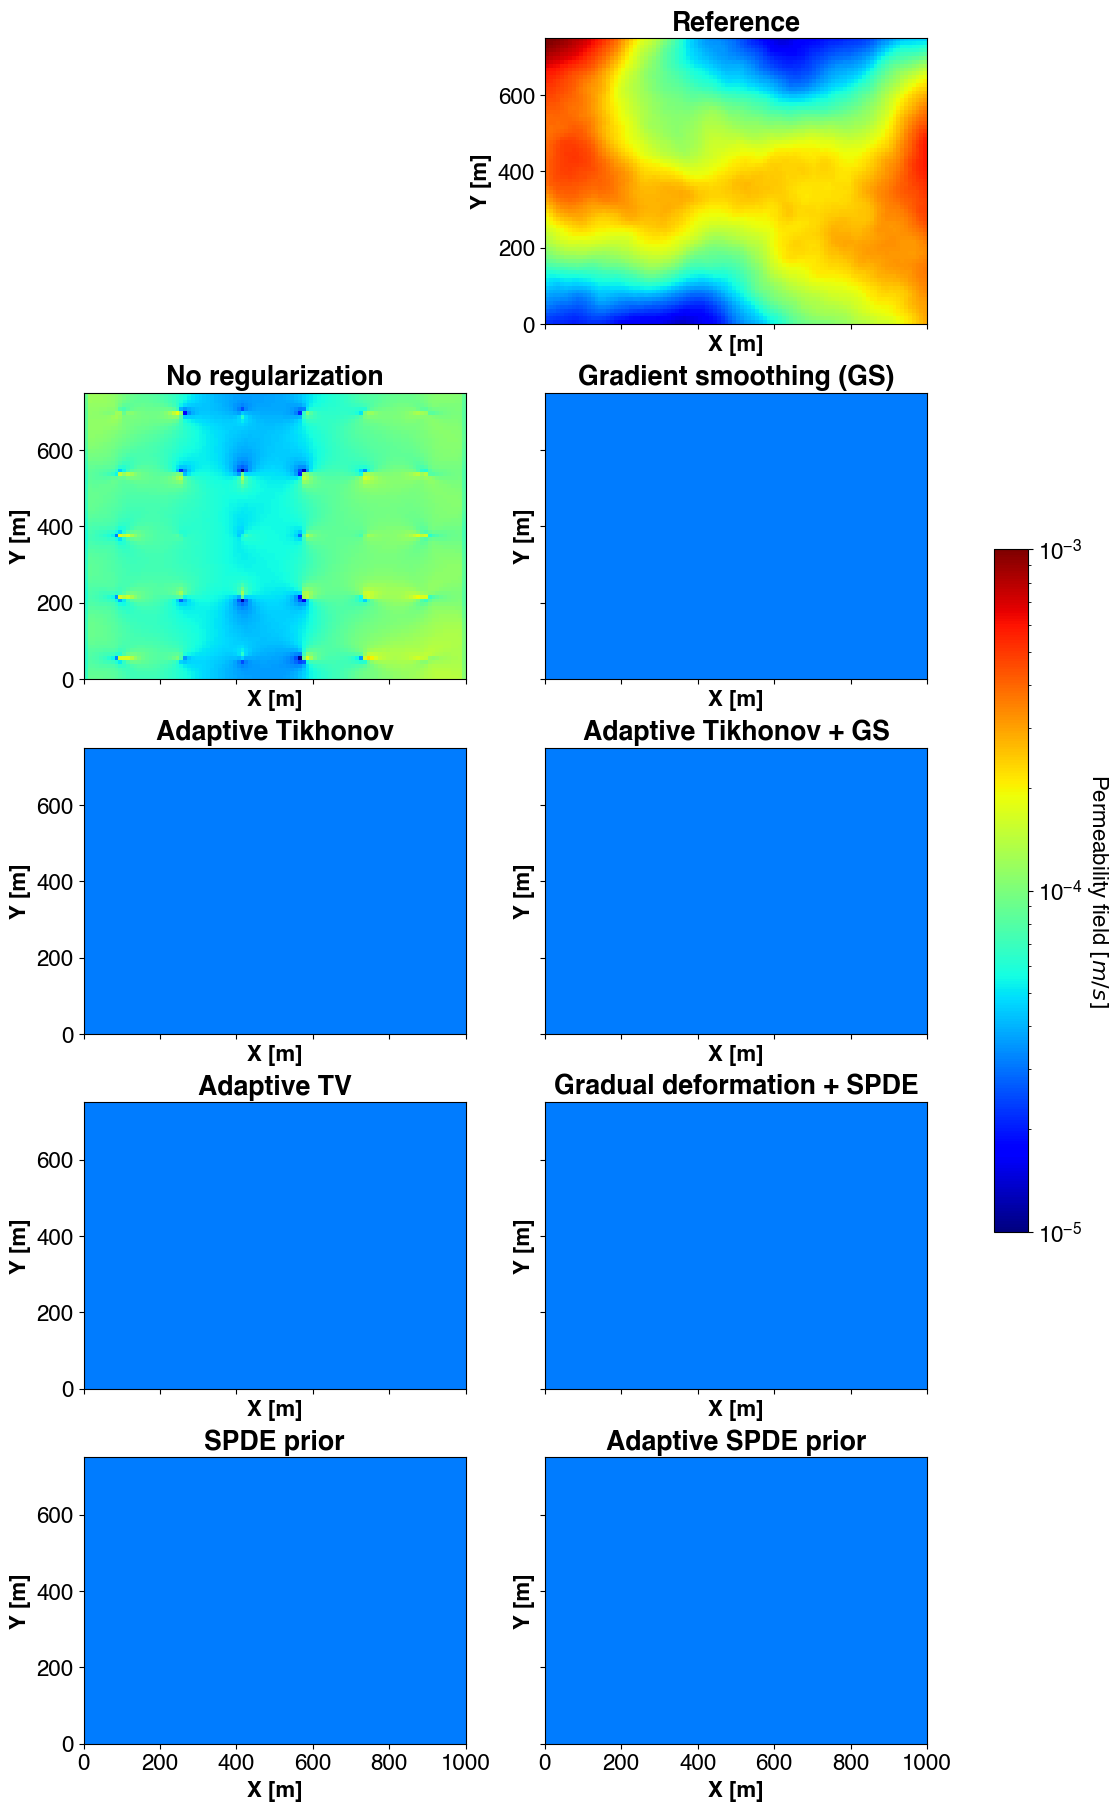

In [45]:
labels = {
    "no_reg": "No regularization",
    "gs": "Gradient smoothing (GS)",
    "tka": "Adaptive Tikhonov",
    "gstka": "Adaptive Tikhonov + GS",
    "tva": "Adaptive TV",
    "sg": "Sigmoid rescaling",
    # "sgtva": "Sigmoid rescaling \n+ Total variation",
    "gdncs": "Gradual deformation + SPDE",
    "spde_prior": "SPDE prior",
    "spde_prior_adaptive": "Adaptive SPDE prior",
}

data = {
    **{
        labels[case]: param.values.reshape(nx, ny, order="F")
        for case, param in params.items()
    },
}
nrows = int((len(data.values())) / 2) + (len(data.values())) % 2

# plotter = ngp.NestedGridPlotter(
#     fig_params={"constrained_layout": True, "figsize": (12, (nrows + 1) * 4.5)},
#     subfigs_params={
#         "nrows": nrows + 1  # np.unique(np.array(prod_grid_locations)[:, 0].round()).size,
#     },
#     subplots_mosaic_params={
#         "upper_row": dict(
#             mosaic=[["ghost1", "ax1-1", "ghost2"]],
#             gridspec_kw=dict(
#                 width_ratios=[1.0, 1.0, 1.0],
#                 height_ratios=[1.0]
#             ),
#             sharey=True,
#             sharex=True,
#         ),
#         **{f"lower_row_{i}": dict(
#             mosaic=[[f"ax{i+2}-{j+1}" for j in range(2)]],
#             # gridspec_kw=dict(
#             #     height_ratios=[1.0, 1.0, 1.0,]
#             # ),
#             sharey=True,
#             sharex=True,
#         ) for i in range(nrows)}
#     },
# )

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (11, nrows * 4.5)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[
                ["ax1-1", "ax1-1"],
                *[[f"ax{i+2}-{j+1}" for j in range(2)] for i in range(nrows)],
            ],
            sharey=True,
            sharex=True,
        )
    },
)

# Plot the permeability
ngp.multi_imshow(
    axes=[plotter.axes[0], *plotter.axes[1 : len(data.values()) + 1]],
    fig=plotter.fig,
    data={"Reference": perm_reference_2d, **data},
    cbar_title="Permeability field $[m/s]$",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "aspect": "equal",
        "norm": LogNorm(vmin=1e-5, vmax=1e-3),
    },
    xlabel="X [m]",
    ylabel="Y [m]",
    cbar_kwargs={"shrink": 0.4},
)

if len(data.values()) % 2 != 0:
    plotter.axes[-1].axis("off")

fname = fig_save_path.joinpath("bench_inversed_perm")
for format in ["png", "pdf"]:
    plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Graphs of residuals

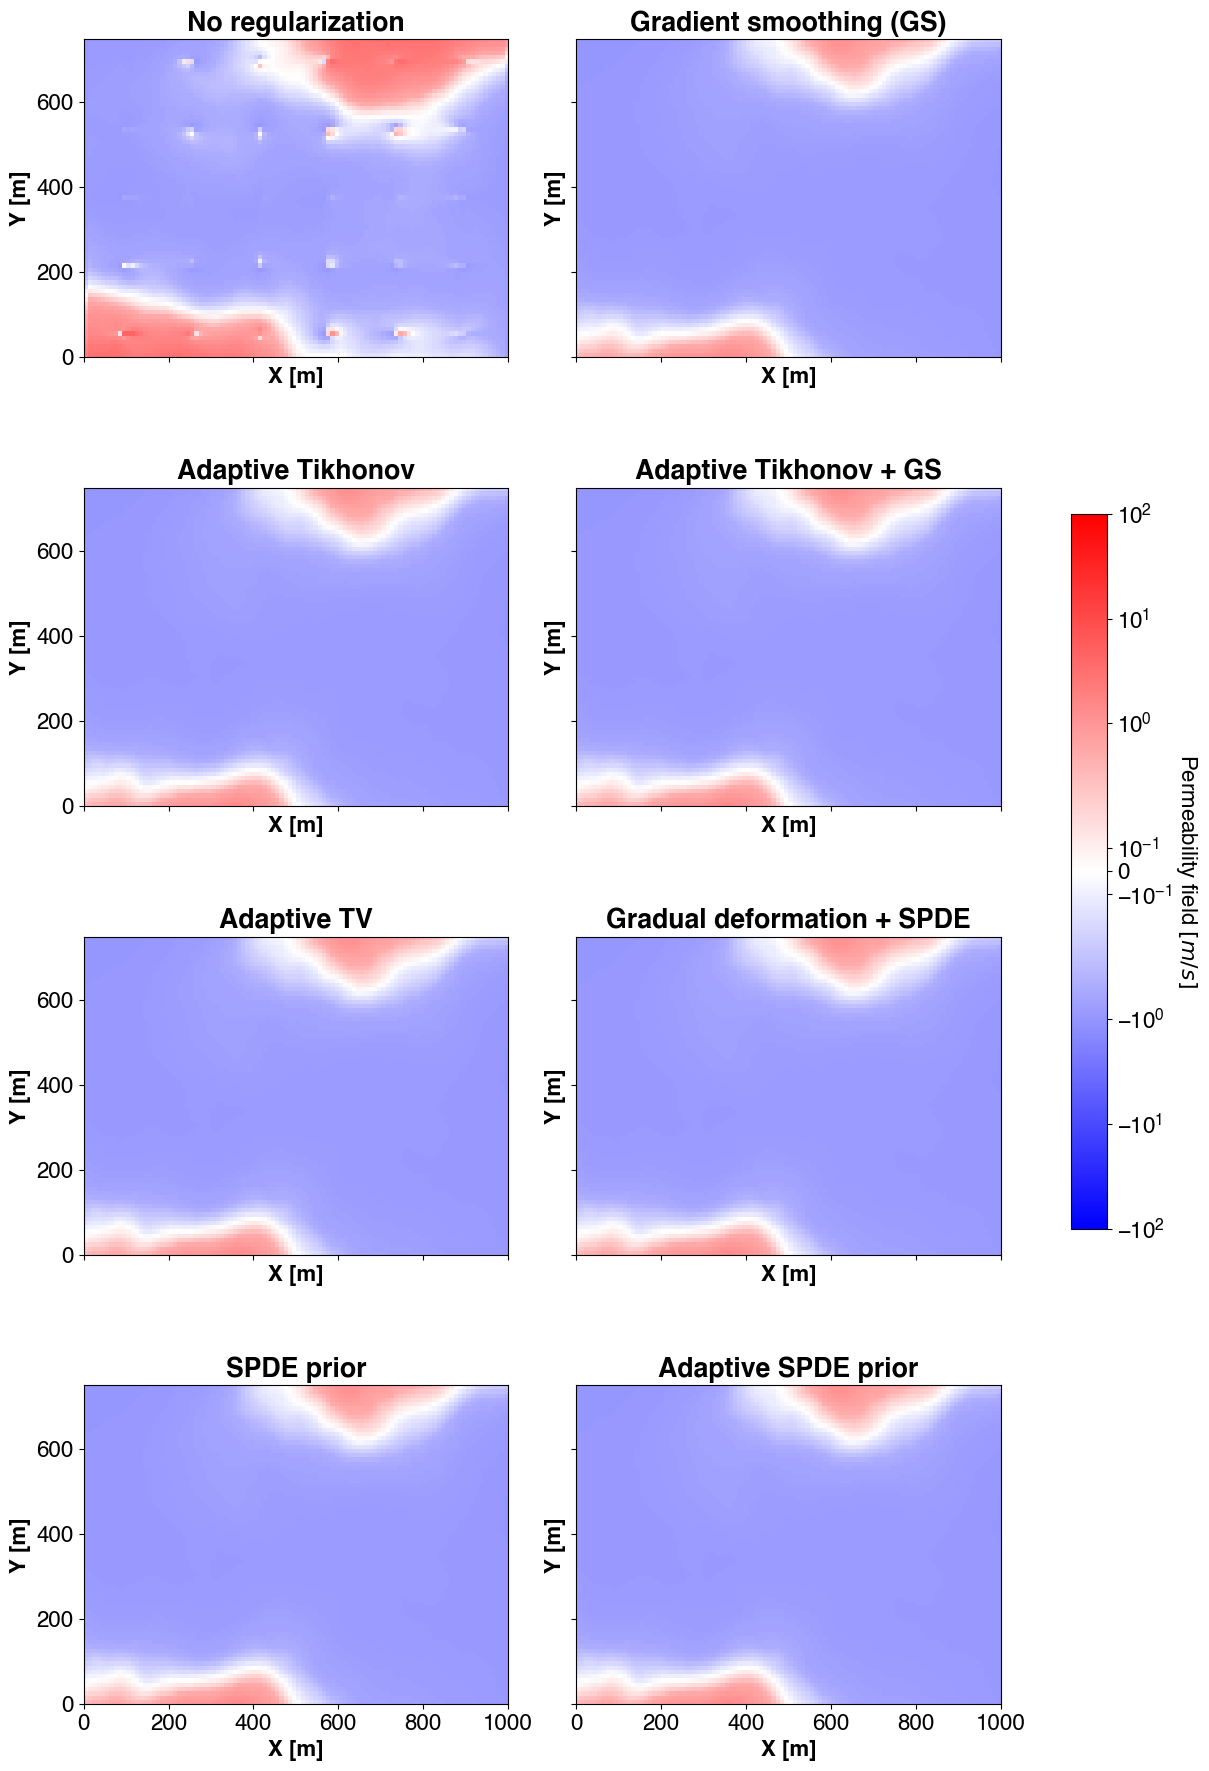

In [50]:
data = {
    labels[case]: (param.values.reshape(nx, ny, order="F") - perm_reference_2d)
    / perm_reference_2d
    for case, param in params.items()
}
nrows = int(len(data.values()) / 2) + len(data.values()) % 2

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, nrows * 4.5)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[[f"ax{i+1}-{j+1}" for j in range(2)] for i in range(nrows)],
            sharey=True,
            sharex=True,
        )
    },
)

# Plot the permeability
ngp.multi_imshow(
    axes=plotter.axes[: len(data.values())],
    fig=plotter.fig,
    data=data,
    cbar_title="Permeability field $[m/s]$",
    imshow_kwargs={
        "cmap": plt.get_cmap("bwr"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "aspect": "equal",
        "norm": SymLogNorm(linthresh=0.5, vmin=-1e2, vmax=1e2),
    },
    xlabel="X [m]",
    ylabel="Y [m]",
    cbar_kwargs={"shrink": 0.4},
    # is_symmetric_cbar=True
)

if len(data.values()) % 2 != 0:
    plotter.axes[-1].axis("off")

fname = fig_save_path.joinpath("bench_inversed_perm_residuals")
for format in ["png", "pdf"]:
    plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Plot the objective functions

INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode


INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUni

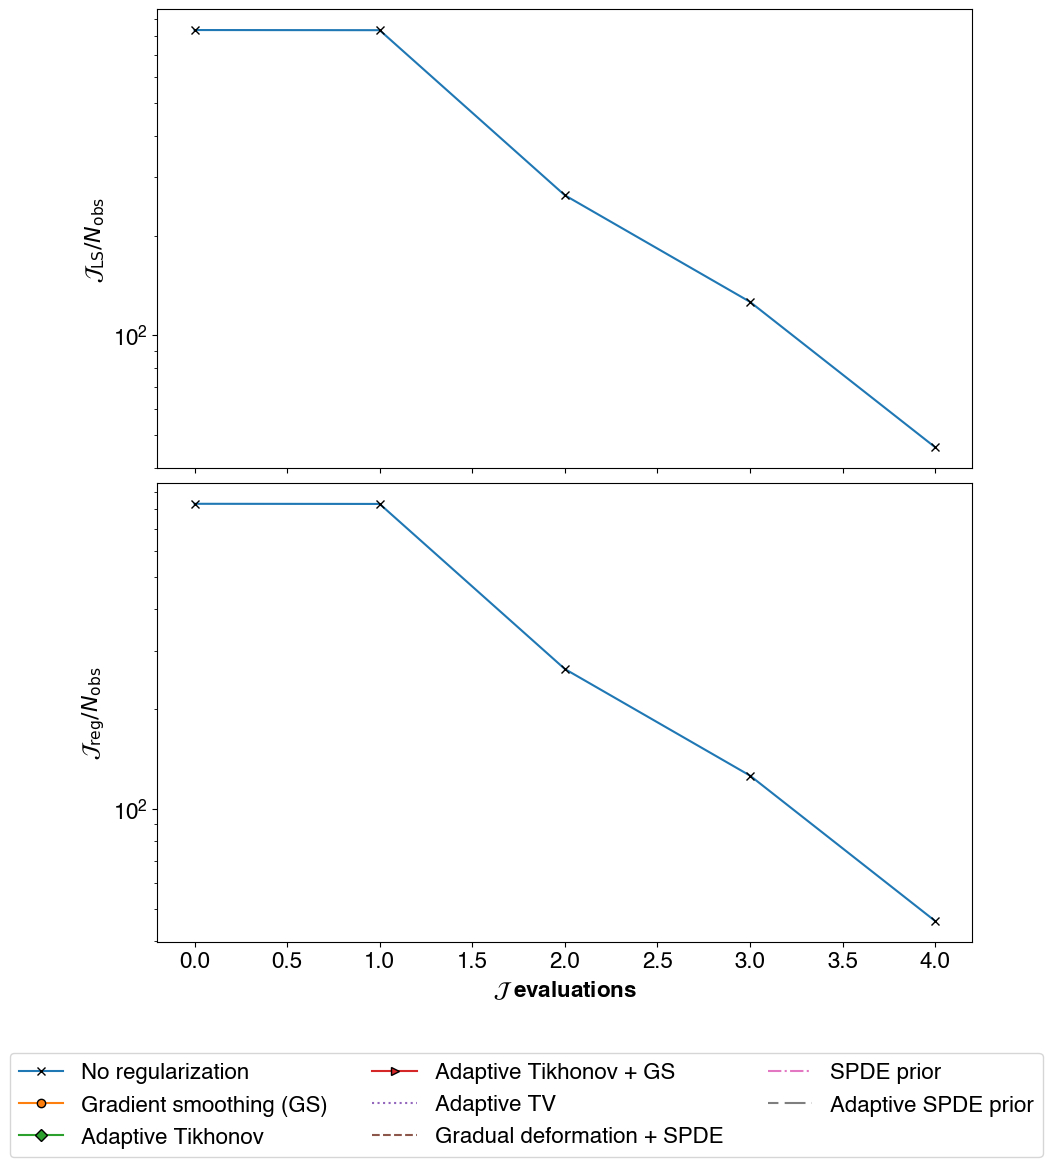

In [47]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (9, 10)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax1-2"]],
            sharey=True,
            sharex=True,
        )
    },
)

linestyles = [
    "solid",
    "solid",
    "solid",
    "solid",
    "dotted",
    "dashed",
    "dashdot",
    (5, (10, 3)),
]
markers = ["x", "o", "D", ">"]

# save obj functions
for i, case in enumerate(params.keys()):
    np.savetxt(
        fig_save_path.joinpath(f"loss_div_nobs_history_{case}.txt"),
        inverse_models[case].loss_scaled_history,
    )

# Ax 1.1
ax = plotter.axes[0]
for i, case in enumerate(params.keys()):
    if linestyles[i] == "solid":
        marker = markers[i]
    else:
        marker = None
    # we need to modify the scaling coefficient in the spde approach
    # ax.semilogy(inverse_models[case].loss_scaled_history /inverse_models[case].scaling_factor / executors[case].data_model.n_obs, label=labels[case], linestyle=linestyles[i], marker=marker, mec="k")
    ax.semilogy(
        np.array(inverse_models[case].loss_ls_history)
        / executors[case].data_model.n_obs,
        label=labels[case],
        linestyle=linestyles[i],
        marker=marker,
        mec="k",
    )
ax.set_ylabel(r"$\mathcal{J}_{\mathrm{LS}} / N_{\mathrm{obs}}$", fontweight="bold")

# Ax 1.2
ax = plotter.axes[1]
for i, case in enumerate(params.keys()):
    if linestyles[i] == "solid":
        marker = markers[i]
    else:
        marker = None
    # we need to modify the scaling coefficient in the spde approach
    ax.semilogy(
        np.array(inverse_models[case].loss_scaled_history)
        / inverse_models[case].scaling_factor
        / executors[case].data_model.n_obs,
        label=labels[case],
        linestyle=linestyles[i],
        marker=marker,
        mec="k",
    )
    # ax.semilogy(np.array(inverse_models[case].loss_ls_history) / executors[case].data_model.n_obs, label=labels[case], linestyle=linestyles[i], marker=marker, mec="k")
ax.set_xlabel(r"$\mathcal{J}$ evaluations", fontweight="bold")
ax.set_ylabel(r"$\mathcal{J}_{\mathrm{reg}} / N_{\mathrm{obs}}$", fontweight="bold")

legend = plotter.add_fig_legend(ncols=3, bbox_y_shift=-0.05)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)

fname = fig_save_path.joinpath("bench_cost_fun")
for format in ["png", "pdf"]:
    plotter.savefig(
        fig_save_path.joinpath(f"{fname}.{format}"),
        format=format,
    )

Notes:
- Toutes les courbes ont le même point de départ sauf l'approche avec des déformations graduelle car le point de départ n'est pas le même.
- Sur la figure  1

- Add a graph with residuals
- Add a graph with objective function decay (use the same scale for all experiments)

## Uncertainty quantification

- Quand il n'y a pas de tirage explicit, peut-etre propager par monte carlo avec 1000 tirage par exemple.
- Regarder comment faire des tirages avec un Hessien inverse.

- Get the approximated hessian diagonal

In [48]:
from pyrtid.utils import extract_hess_inv_diag

hess_diag = extract_hess_inv_diag(res.hess_inv)
std = np.sqrt(hess_diag)

std_perm = np.abs(std) * np.abs(np.exp(res.x))

In [49]:
import numpy as np
from scipy.optimize import LbfgsInvHessProduct

from pyrtid.utils.types import NDArrayFloat

from scipy.sparse import linalg as splinalg
import scipy.sparse as sparse
import sys

# def recover_matrix_from_operator(lin_op, n):
#     # Recover matrix from linear operator using unit vectors (slow)
#     return sp.sparse.vstack(sp.sparse.csc(lin_op(unit_vector.toarray())) for unit_vector in sp.sparse.eye(n).tocsc())

# def sparse_cholesky(hess_inv): # The input matrix A must be a sparse symmetric positive-definite.

#   n = hess_inv.shape[0]
#   # Aop = sp.sparse.linalg.LinearOperator(hess_inv.shape, matvec=hess_inv.matvec)
#   Aop = recover_matrix_from_operator(hess_inv, n)

#   LU = splinalg.splu(Aop, diag_pivot_thresh=0) # sparse LU decomposition

#   if ( LU.perm_r == np.arange(n) ).all() and ( LU.U.diagonal() > 0 ).all(): # check the matrix A is positive definite.
#     return LU.L.dot( sparse.diags(LU.U.diagonal()**0.5) )
#   else:
#     sys.exit('The matrix is not positive definite')


def get_uq_from_lbfgsb_invhess(
    param: dminv.AdjustableParameter, hess_inv: LbfgsInvHessProduct
) -> NDArrayFloat:
    """
    Quantify the uncertainty from the ibverse lbfgsb hessian.

    If no preconditioning, then simply solve N_s symstem to extract the diagonal.
    Otherwise, perform a sparse cholesky factorization and generated samples that are
    backconditioned to propagate the uncertainty.
    """
    if param.preconditioner is None:
        # We solve
        return extract_hess_inv_diag(hess_inv)
    else:
        # uncertainty propagation
        try:
            param.preconditioner...

    # Try the error propagation with the preconditioner otehrwise, if n < 200...
    # TODO !
    # Otherwise, error propagation with cholesky decomposition
    U = sp.linalg.cholesky(hess_inv.todense(), lower=False)


def extract_hess_inv_diag(hess_inv: LbfgsInvHessProduct) -> NDArrayFloat:
    """
    Extract efficiently the diagonal of the L-BFGS approximate inverse Hessian.

    It relies on the linear operator `matvec` operation and consequenlty does not
    require to build the dense matrix which is much longer and generally untractable
    for large-scale problems.

    Parameters
    ----------
    hess_inv : LbfgsInvHessProduct
        Linear operator for the L-BFGS approximate inverse Hessian.

    Returns
    -------
    NDArrayFloat
        The diagonal of the L-BFGS approximated inverse Hessian.
    """
    n_params = hess_inv.shape[0]
    hess_inv_diag = np.zeros(n_params)
    for i in range(n_params):
        v = np.zeros(n_params)
        v[i] = 1.0
        hess_inv_diag[i] = hess_inv.matvec(v)[i]
    return hess_inv_diag

SyntaxError: invalid syntax (4210281664.py, line 44)

In [ ]:
get_uq_from_lbfgsb_invhess(params[first_case], res.hess_inv)

In [ ]:
std

In [ ]:
plt.imshow(
    std_perm.reshape(nx, ny, order="F").T,
    origin="lower",
    aspect="equal",
    cmap=plt.get_cmap("jet"),
    norm=LogNorm(),
)
plt.colorbar()

In [ ]:
hess_inv_diag = extract_hess_inv_diag(res.hess_inv)

In [ ]:
factor_95_pct_interval = (
    1.96  # number of sigma to get the 95% interval in the gaussian case
)
factor_99_pct_interval = (
    2.575829  # number of sigma to get the 99% interval in the gaussian case
)

plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 4)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

interval_95_pct_no_reg = std_perm.reshape(nx, ny, order="F") * factor_95_pct_interval
logK_residuals_no_reg = np.abs(
    executors[case].inv_model.parameters_to_adjust[0].values - perm_reference_2d
)

ngp.multi_imshow(
    plotter.axes,
    fig=plotter.fig,
    data={
        "99% interval (uncertainty)": interval_95_pct_no_reg,
        "residuals": logK_residuals_no_reg,
    },
    cbar_title="LogK - hydraulic conductivity (m2/d)",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        # "cmap": plt.get_cmap("bwr"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "aspect": "equal",
        "norm": LogNorm(vmin=1e-5, vmax=1e-2),
        # "vmin": 0.0,
        # "vmax": 2.5,
    },
    xlabel="X [m]",
    ylabel="Y [m]",
)
plotter.fig.suptitle(
    "True residuals vs. 99% confidence interval - No reg case",
    size=20,
    fontweight="bold",
)